# 1. 데이터셋 준비
- 데이터셋: Oxford-IIIT Pet Dataset
- 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성
    - 마스크: 각 픽셀에 대한 범주 레이블
        - class 1: 반려동물이 속한 픽셀
        - class 2: 반려동물과 인접한 픽셀
        - class 3: 위에 속하지 않는 경우/ 주변 픽셀

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 10
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [3]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

- 이미지를 사전에 정의한 (128, 128) 크기로 변경 후 자료형 변경
- 원본 이미지 픽셀 정규화
- 마스크는 0, 1, 2 값을 갖도록 1 차감

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.int32)>


- 전처리 함수를 훈련 셋, 테스트 셋에 매핑
- 미니배치로 분할

In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

- 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어있음

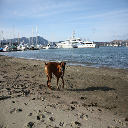

In [7]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

- 배치에서 첫 번째 이미지

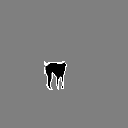

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2) * 255.
cv2_imshow(mask)

- 마스크 이미지
- 범위가 0~2 이므로 2로 나눈 뒤 255를 곱하면 RGB 이미지로 표현 가능

# 2. U-Net 모델(인코더-디코더)
- VGG16 사전 학습 모델을 인코더로 활용하는 U-Net 모델

In [9]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

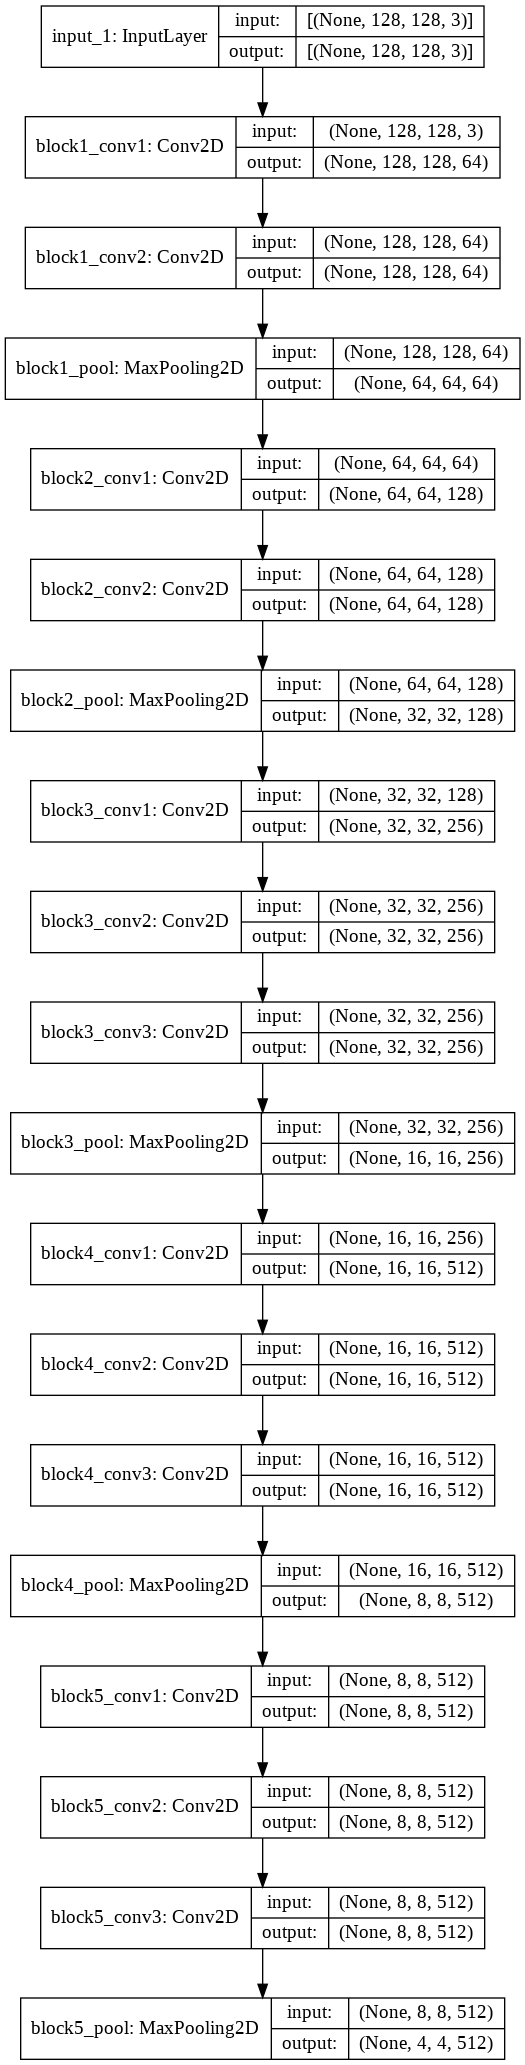

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

- 합성곱 층과 풀링 층을 직렬로 연결한 구조
- U-Net의 인코더로 사용
    - 원본 이미지 중 같은 범주에 속하는 픽셀 결합 -> 점진적으로 이미지를 더 작은 크기로 축소
    - 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0, 1, 2 중 하나로 분류하는 역할

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output,
                         ])

- 사전 학습 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 지정
- VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정 -> 다양한 피쳐를 추출하는 인코더 모델 정의
    - VGG16 모델로부터 5개 출력을 가져와 사용
    - f_model 변수에 Feature Extractor 모델 정의: 1개의 입력과 5개의 출력

In [12]:
# 파라미터 고정
f_model.trainable = False

- 사전 학습 파라미터를 인코더에 그대로 사용

In [13]:
# U-Net 구조로 모델 정의
i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

- 인코더 부분에서 5개의 출력을 가져와 디코더의 입력으로 전달(업샘플링)
    - 업샘플링: 축소된 이미지를 원래 이미지 크기로 복원하는 과정
    - 제일 작은 텐서(8, 8, 512)에서 시작해 조금씩 크기를 키워 나가며 중간 출력과 합침
- U-Net 디코더를 구성할 때 입력 텐서와 출력 텐서의 크기를 맞추는 과정이 중요함
- 인코더의 Conv2D 레이어에 의한 합성곱 변환은 Conv2DTranspose 레이어를 통해 반대 방향으로 되돌릴 수 있음

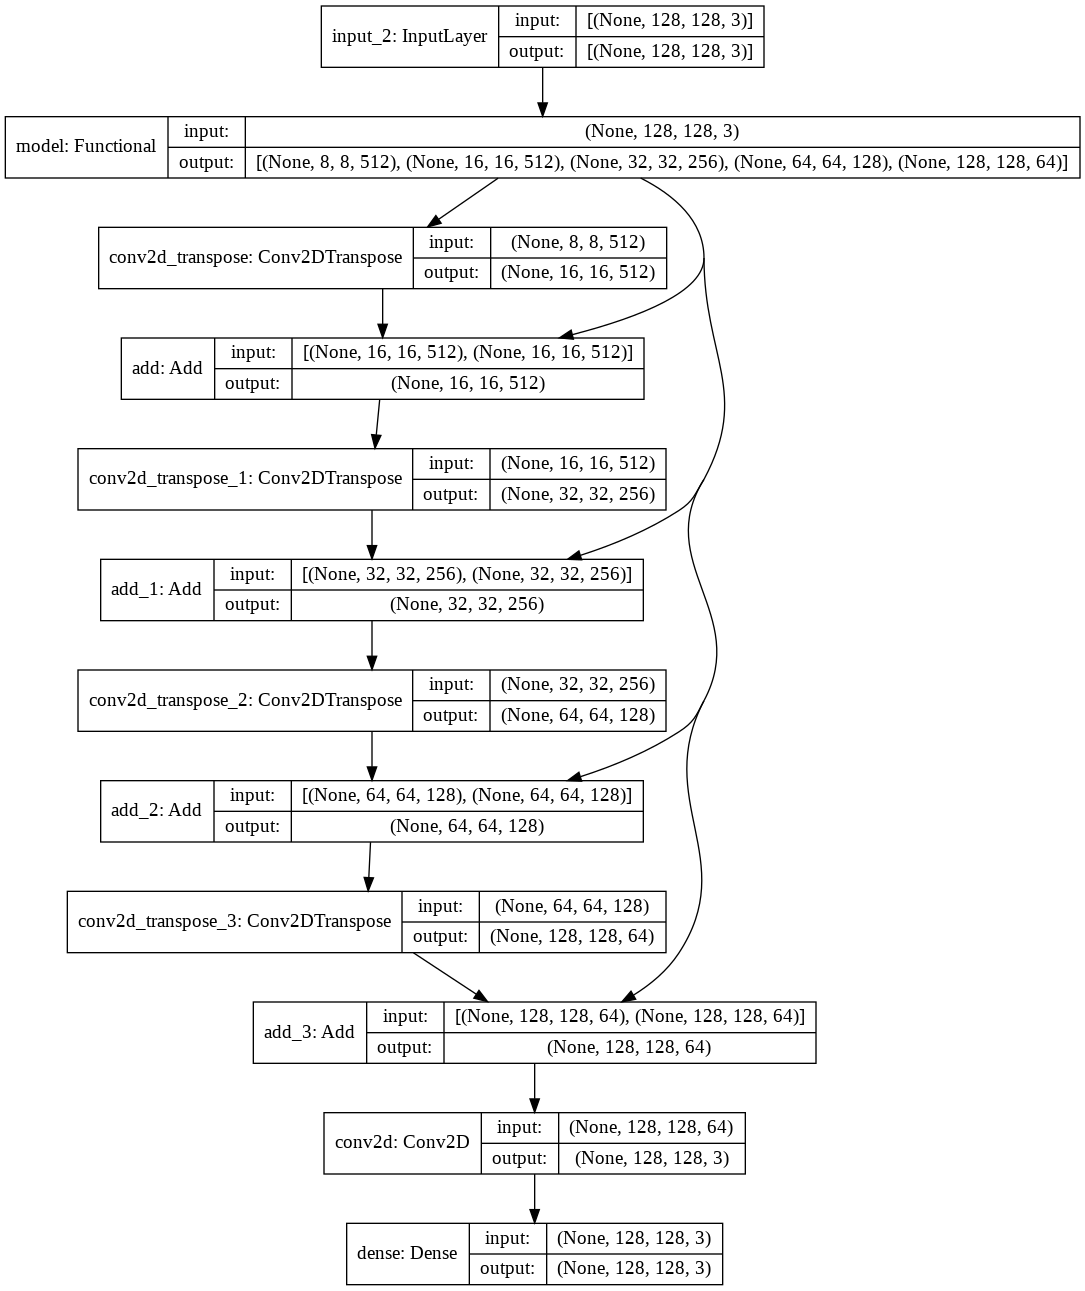

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

- 모델 구조 시각화
    - 인코더 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인
    - 각 레이어의 입출력 텐서 크기 동일

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 8, 8, 512),  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 512)  2359808     model[0][0]                      
__________________________________________________________________________________________________
add (Add)                       (None, 16, 16, 512)  0           conv2d_transpose[0][0]           
                                                                 model[0][1]                

- 14,714,688의 파라미터는 학습되지 않도록 고정

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(loss=loss_f, optimizer=opt, metrics=['acc'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/10
230/230 [==============================] - 17s 53ms/step - loss: 0.6568 - acc: 0.7183
Epoch 2/10
230/230 [==============================] - 15s 53ms/step - loss: 0.4925 - acc: 0.8274
Epoch 3/10
230/230 [==============================] - 14s 53ms/step - loss: 0.4542 - acc: 0.8362
Epoch 4/10
230/230 [==============================] - 15s 53ms/step - loss: 0.4274 - acc: 0.8436
Epoch 5/10
230/230 [==============================] - 14s 52ms/step - loss: 0.4076 - acc: 0.8481
Epoch 6/10
230/230 [==============================] - 14s 52ms/step - loss: 0.3924 - acc: 0.8513
Epoch 7/10
230/230 [==============================] - 15s 53ms/step - loss: 0.3828 - acc: 0.8535
Epoch 8/10
230/230 [==============================] - 14s 52ms/step - loss: 0.3761 - acc: 0.8550
Epoch 9/10
230/230 [==============================] - 14s 52ms/step - loss: 0.3691 - acc: 0.8576
Epoch 10/10
230/230 [==============================] - 14s 52ms/step - loss: 0.3664 - acc: 0.8577


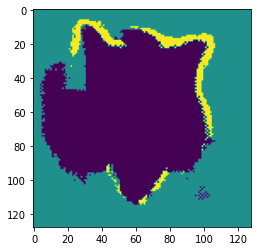

In [18]:
# 1개 배치(16개 이미지) 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

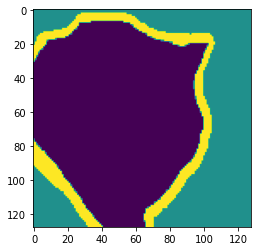

In [19]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128, 128)))